## Подготовка данных

In [1]:
import os
from analyze import *
import spacy
from spacy.matcher import Matcher

In [2]:
dataset_filename = os.path.join("..", "data", "belta_articles.json")

# Если датасет не существует – генерируем его
# if not os.path.exists(dataset_filename):
#     generate_news_dataset(filename=dataset_filename)
# else:
#     print(f"Файл {dataset_filename} уже существует. Пропускаем генерацию.")

# Загружаем данные из JSON в DataFrame
with open(dataset_filename, "r", encoding="utf-8") as f:
    data = json.load(f)
df = pd.DataFrame(data)

## Анализ текста

Общее количество статей: 7499

Статистика по длине текстов (в словах):
count    7499.000000
mean      244.969729
std       360.887528
min         1.000000
25%       113.000000
50%       173.000000
75%       260.000000
max      8751.000000
Name: text_length, dtype: float64

Статистика по длине заголовков (в словах):
count    7499.000000
mean       10.441792
std         2.474337
min         4.000000
25%         9.000000
50%        10.000000
75%        12.000000
max        21.000000
Name: title_length, dtype: float64


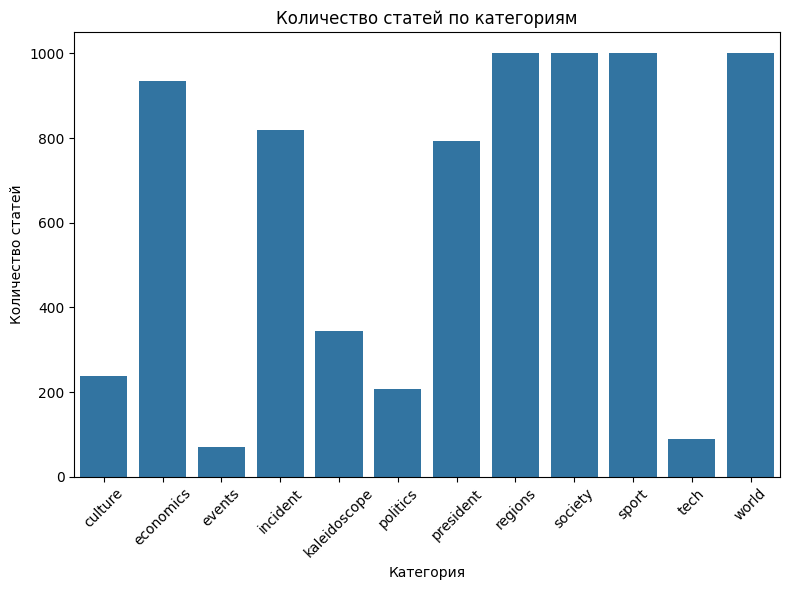

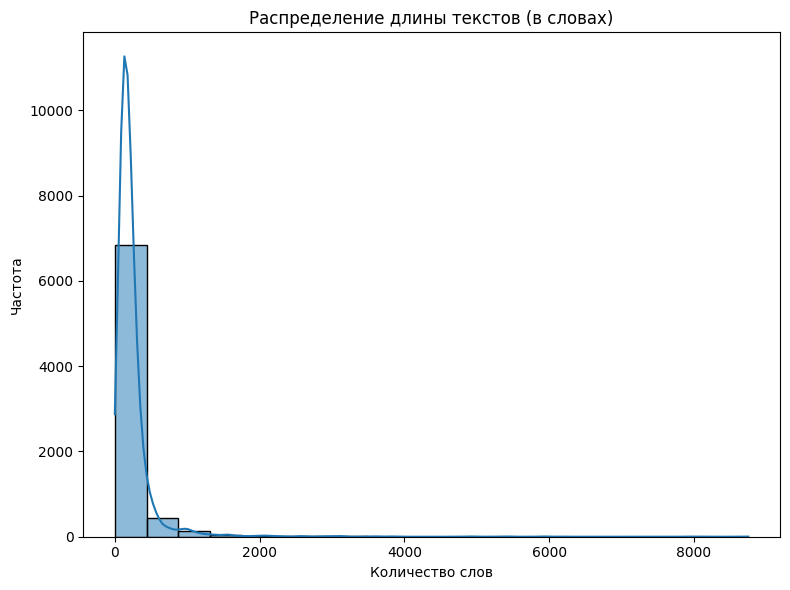

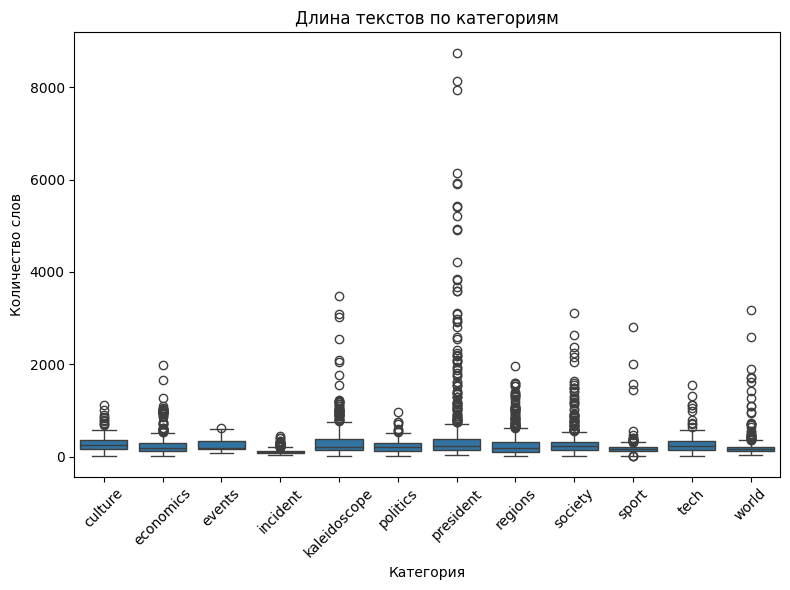

In [3]:
# Базовый анализ данных
basic_text_analysis(df)

In [4]:
# Загрузка модели spaCy (ru_core_news_sm )
# !python -m spacy download ru_core_news_sm
try:
    nlp = spacy.load("ru_core_news_sm")
    matcher = Matcher(nlp.vocab)
except Exception as e:
    print("Ошибка загрузки модели spaCy. Убедитесь, что ru_core_news_sm  установлен.")

In [5]:
# Определяем список названий месяцев на русском языке
months = ["января", "февраля", "марта", "апреля", "мая", "июня",
          "июля", "августа", "сентября", "октября", "ноября", "декабря"]

# Задаем паттерн для сопоставления шапки.
pattern = [
    {"IS_DIGIT": True},                           # день
    {"IS_SPACE": True, "OP": "+"},
    {"LOWER": {"IN": months}},                    # месяц
    {"IS_PUNCT": True, "OP": "?"},                # запятая (опционально, если не всегда)
    {"IS_SPACE": True, "OP": "*"},
    {"IS_TITLE": True, "OP": "+"},                # название города (одно или несколько слов)
    {"IS_SPACE": True, "OP": "*"},
    {"TEXT": "/", "OP": "?"},                     # слэш (начало уточняющей части)
    {"IS_ALPHA": True, "OP": "*"},                # возможный текст (например, "Корр")
    {"TEXT": ".", "OP": "?"},                     # точка после "Корр", если есть
    {"IS_ALPHA": True, "OP": "*"},                # оставшийся текст (например, "БЕЛТА")
    {"TEXT": "/", "OP": "?"}                      # закрывающий слэш
]

matcher.add("HEADER", [pattern])

In [6]:
def remove_header_spacy(text):
    doc = nlp(text)
    matches = matcher(doc)
    if matches:
        # Проверяем, начинается ли первый матч с первого токена (т.е. шапка в начале)
        match_id, start, end = matches[0]
        if start == 0:
            # Возвращаем текст, начиная с токена после найденного паттерна
            return doc[end:].text.lstrip()
    return text  # если паттерн не найден, возвращаем исходный текст

In [7]:
# Чистим шапку
df["text"] = df["text"].apply(remove_header_spacy)


Предобработка текстов (токенизация, лемматизация, удаление стоп-слов и пунктуации)...

Категория: culture
Общее число слов: 45797
Число уникальных слов: 8578
Коэффициент разнообразия (уникальные/все): 0.187
Топ-10 ключевых слов:
  год: 503
  белорусский: 425
  фильм: 380
  беларусь: 372
  минск: 285
  фестиваль: 257
  конкурс: 237
  кино: 221
  культура: 220
  белта/.: 215


/home/pavel/projects/python/nlp_hse_lab/src/analyze.py:210: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words_list), y=list(freq_list), palette="magma")


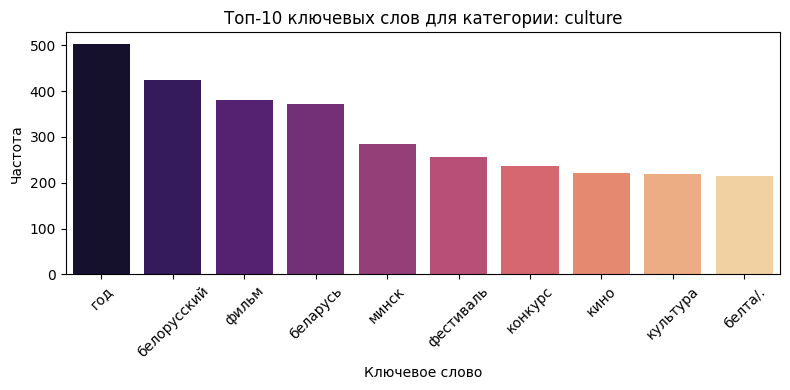


Категория: economics
Общее число слов: 164736
Число уникальных слов: 16615
Коэффициент разнообразия (уникальные/все): 0.101
Топ-10 ключевых слов:
  год: 2476
  беларусь: 1737
  белорусский: 1152
  предприятие: 1009
  страна: 921
  минск: 910
  белта/.: 889
  /корр: 825
  развитие: 787
  проект: 769


/home/pavel/projects/python/nlp_hse_lab/src/analyze.py:210: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words_list), y=list(freq_list), palette="magma")


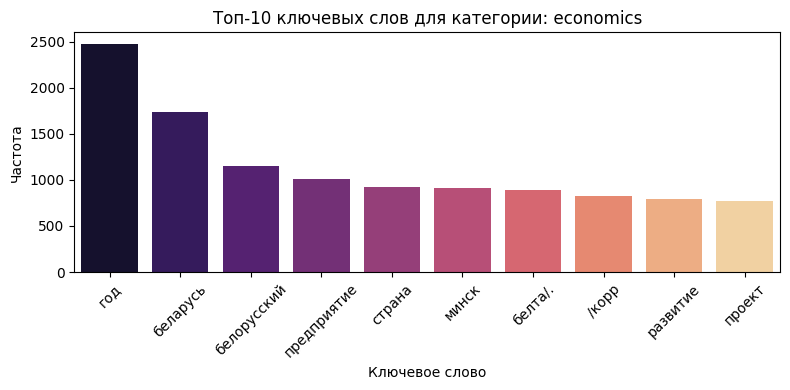


Категория: events
Общее число слов: 13449
Число уникальных слов: 4186
Коэффициент разнообразия (уникальные/все): 0.311
Топ-10 ключевых слов:
  белорусский: 132
  год: 97
  выставка: 82
  фильм: 78
  январь: 72
  театр: 66
  зритель: 59
  представить: 57
  /корр: 55
  белта/.: 55


/home/pavel/projects/python/nlp_hse_lab/src/analyze.py:210: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words_list), y=list(freq_list), palette="magma")


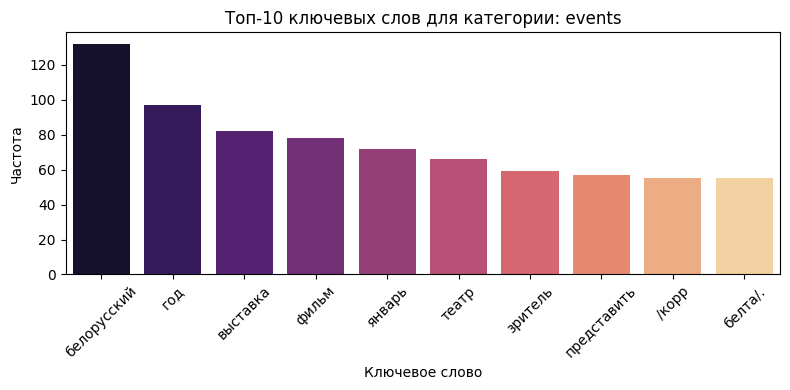


Категория: incident
Общее число слов: 64584
Число уникальных слов: 7714
Коэффициент разнообразия (уникальные/все): 0.119
Топ-10 ключевых слов:
  пожар: 862
  минск: 855
  сообщить: 839
  белта/.: 819
  /корр: 817
  белта: 810
  водитель: 709
  район: 679
  дом: 607
  автомобиль: 568


/home/pavel/projects/python/nlp_hse_lab/src/analyze.py:210: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words_list), y=list(freq_list), palette="magma")


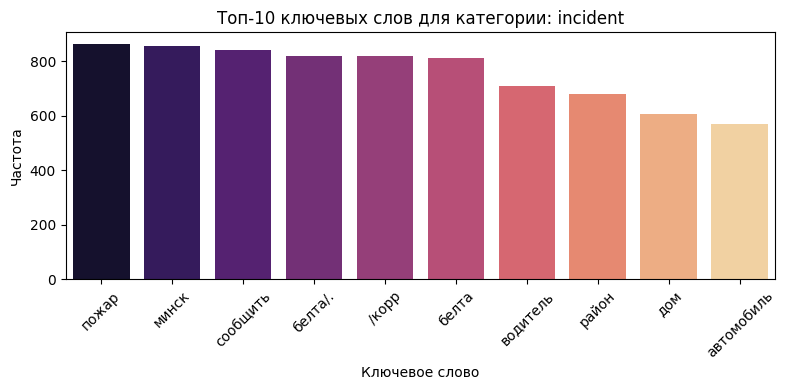


Категория: kaleidoscope
Общее число слов: 85666
Число уникальных слов: 21876
Коэффициент разнообразия (уникальные/все): 0.255
Топ-10 ключевых слов:
  год: 1056
  і: 396
  время: 323
  новый: 259
  минск: 256
  человек: 256
  век: 255
  первый: 237
  день: 213
  ў: 206


/home/pavel/projects/python/nlp_hse_lab/src/analyze.py:210: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words_list), y=list(freq_list), palette="magma")


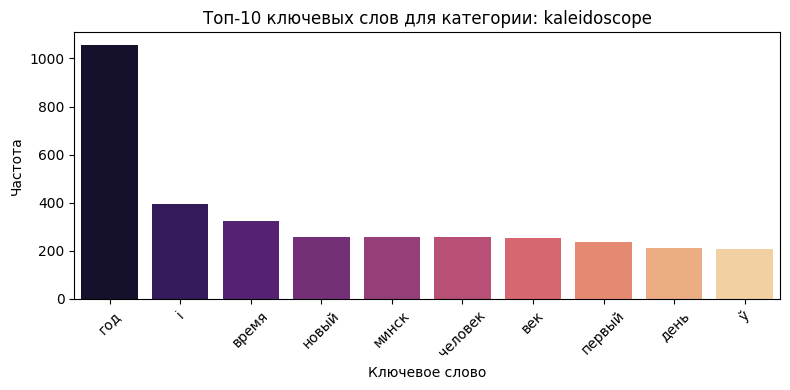


Категория: politics
Общее число слов: 33301
Число уникальных слов: 5257
Коэффициент разнообразия (уникальные/все): 0.158
Топ-10 ключевых слов:
  беларусь: 847
  страна: 361
  государство: 265
  международный: 261
  республика: 248
  сотрудничество: 242
  белорусский: 240
  дело: 215
  минск: 211
  министр: 209


/home/pavel/projects/python/nlp_hse_lab/src/analyze.py:210: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words_list), y=list(freq_list), palette="magma")


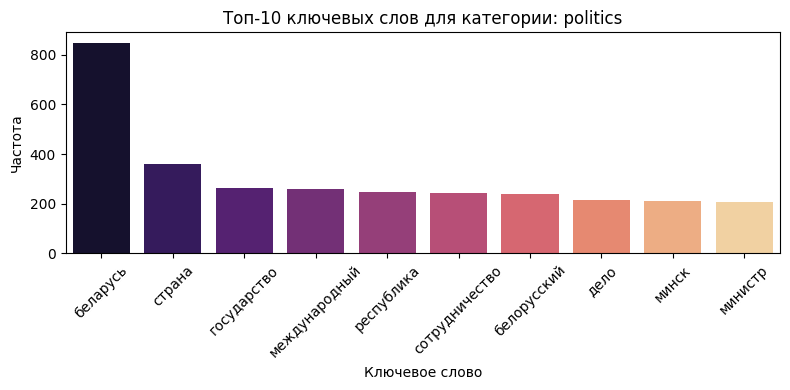


Категория: president
Общее число слов: 230036
Число уникальных слов: 20309
Коэффициент разнообразия (уникальные/все): 0.088
Топ-10 ключевых слов:
  лукашенко: 4035
  беларусь: 3413
  президент: 3055
  александр: 2938
  государство: 2513
  год: 1813
  глава: 1763
  страна: 1730
  белорусский: 1530
  человек: 1360


/home/pavel/projects/python/nlp_hse_lab/src/analyze.py:210: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words_list), y=list(freq_list), palette="magma")


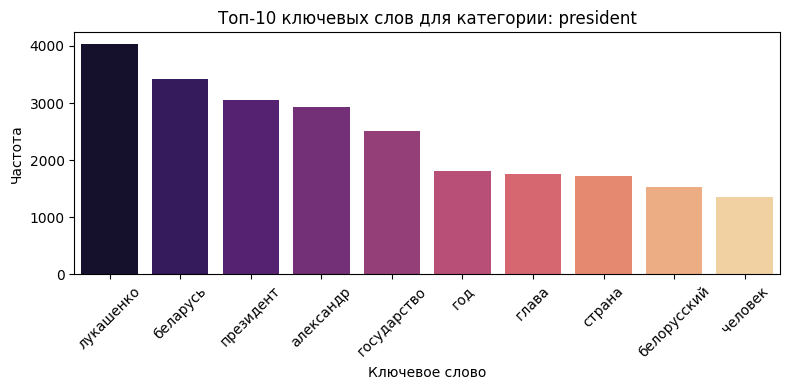


Категория: regions
Общее число слов: 179605
Число уникальных слов: 20902
Коэффициент разнообразия (уникальные/все): 0.116
Топ-10 ключевых слов:
  год: 1963
  январь: 1150
  область: 1007
  белта/.: 936
  /корр: 900
  человек: 885
  район: 811
  работа: 790
  минск: 727
  белта: 701


/home/pavel/projects/python/nlp_hse_lab/src/analyze.py:210: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words_list), y=list(freq_list), palette="magma")


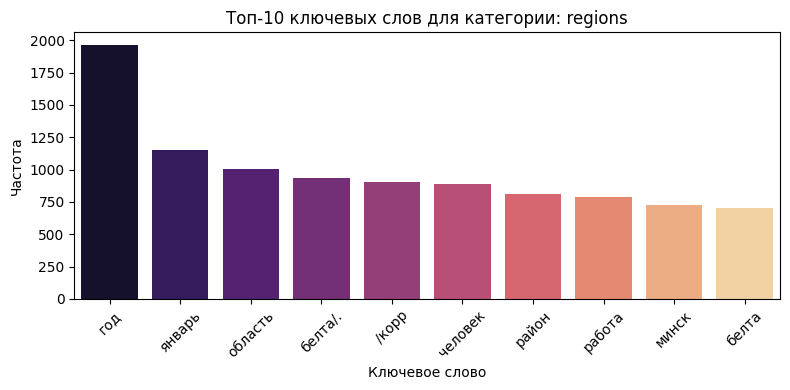


Категория: society
Общее число слов: 188538
Число уникальных слов: 21308
Коэффициент разнообразия (уникальные/все): 0.113
Топ-10 ключевых слов:
  беларусь: 3039
  выбор: 2014
  год: 1766
  страна: 1364
  январь: 1198
  минск: 1138
  президент: 996
  белта/.: 917
  избирательный: 904
  /корр: 889


/home/pavel/projects/python/nlp_hse_lab/src/analyze.py:210: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words_list), y=list(freq_list), palette="magma")


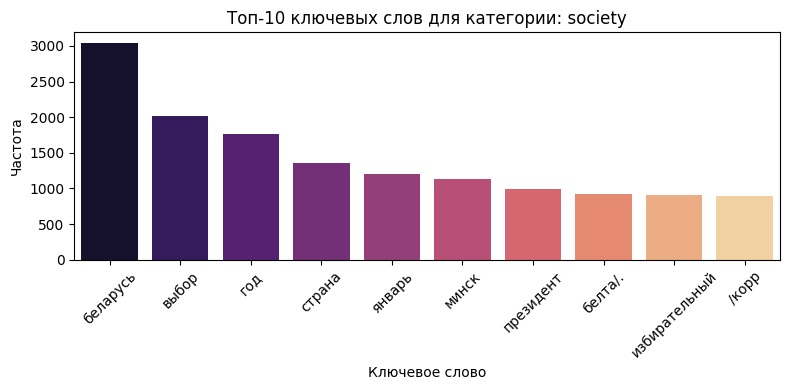


Категория: sport
Общее число слов: 133231
Число уникальных слов: 12245
Коэффициент разнообразия (уникальные/все): 0.092
Топ-10 ключевых слов:
  минск: 1345
  матч: 1268
  команда: 1190
  белта/.: 981
  /корр: 980
  сообщать: 855
  поединок: 847
  корреспондент: 836
  белорусский: 826
  второй: 819


/home/pavel/projects/python/nlp_hse_lab/src/analyze.py:210: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words_list), y=list(freq_list), palette="magma")


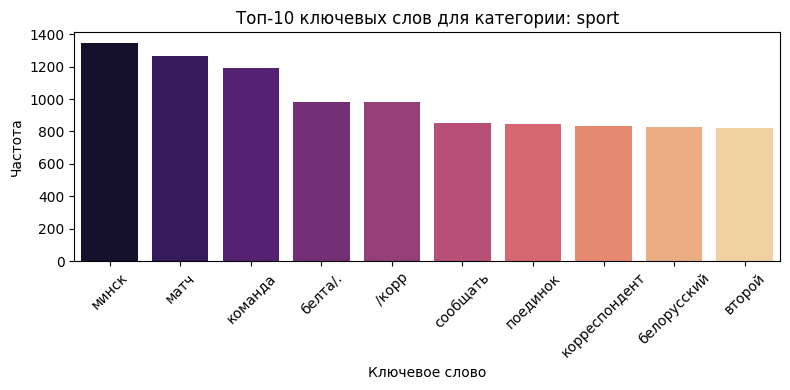


Категория: tech
Общее число слов: 19770
Число уникальных слов: 5293
Коэффициент разнообразия (уникальные/все): 0.268
Топ-10 ключевых слов:
  год: 116
  huawei: 106
  технология: 98
  проект: 93
  система: 92
  компания: 84
  рубль: 80
  новый: 80
  а1: 71
  минск: 69


/home/pavel/projects/python/nlp_hse_lab/src/analyze.py:210: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words_list), y=list(freq_list), palette="magma")


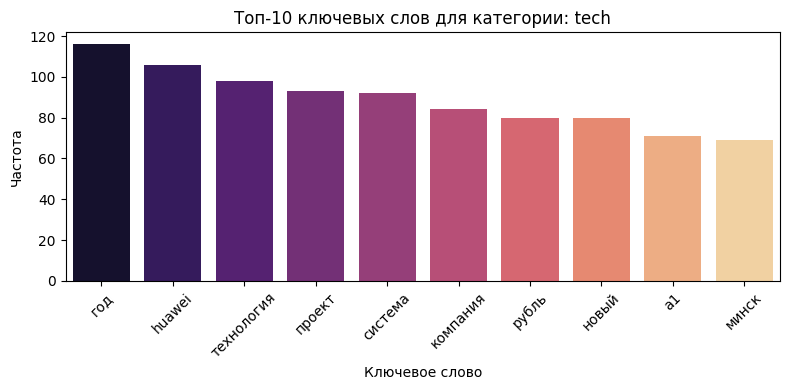


Категория: world
Общее число слов: 134037
Число уникальных слов: 16126
Коэффициент разнообразия (уникальные/все): 0.120
Топ-10 ключевых слов:
  январь: 1471
  год: 1174
  сша: 1170
  минск: 981
  /корр: 973
  белта/.: 958
  трамп: 901
  президент: 806
  страна: 769
  заявить: 716


/home/pavel/projects/python/nlp_hse_lab/src/analyze.py:210: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words_list), y=list(freq_list), palette="magma")


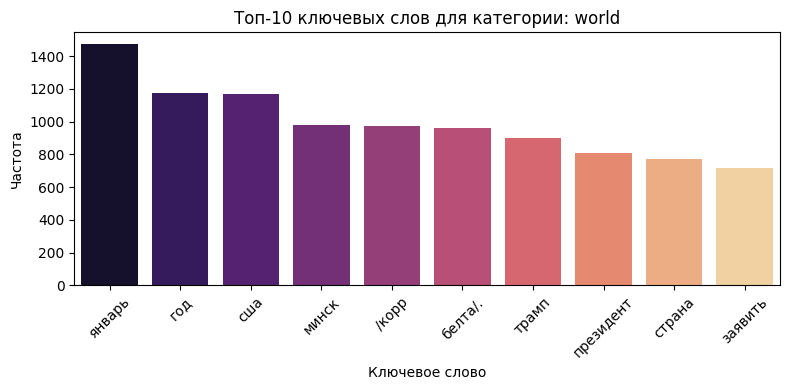

/home/pavel/projects/python/nlp_hse_lab/src/analyze.py:222: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categories, y=ratios, palette="viridis")


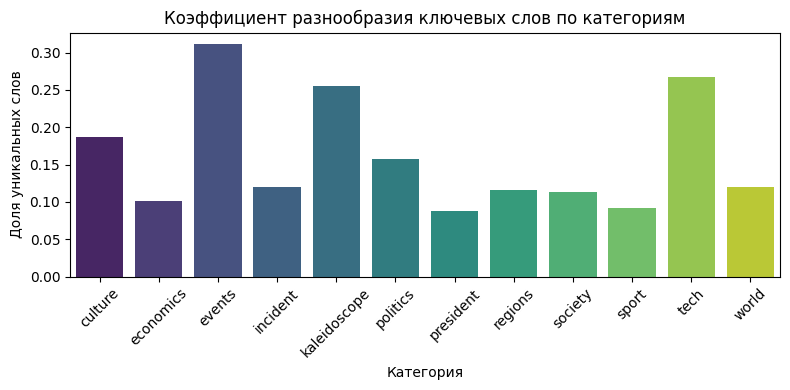

In [8]:
print("\nПредобработка текстов (токенизация, лемматизация, удаление стоп-слов и пунктуации)...")
processed_texts = preprocess_texts(df["text"], nlp)

# Анализ ключевых слов по категориям
analyze_keywords_by_category(df, processed_texts)

## Выводы